In [4]:
RESULT_DIR = "/Users/niko/Downloads/results"
# RESULT_DIR = "/home/niko/Downloads/results"

In [5]:
import os
import json

In [6]:
files = os.listdir(RESULT_DIR)
files = [f for f in files if f.endswith(".json")]

with open(os.path.join(RESULT_DIR, files[0]), "r") as f:
    final = json.load(f)

with open(os.path.join(RESULT_DIR, files[1]), "r") as f:
    partials = json.load(f)

In [20]:
threshold = 0.5

filtered_partials = []
for entry in partials:
    filtered_result = [
        word for word in entry['result']['result']
        if word['conf'] >= threshold
    ]
    # Strukturell identisch, nur mit gefilterten Wörtern
    filtered_entry = {
        **entry,
        'result': {
            **entry['result'],
            'result': filtered_result
        }
    }
    filtered_partials.append(filtered_entry)

In [21]:
filtered_word_count = sum(len(entry['result']['result']) for entry in filtered_partials)
word_count = sum(len(entry['result']['result']) for entry in partials)
print(word_count)
print(filtered_word_count)

2780
2543


In [22]:
partials = filtered_partials

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [28]:
window_start = 300
window_end = 361

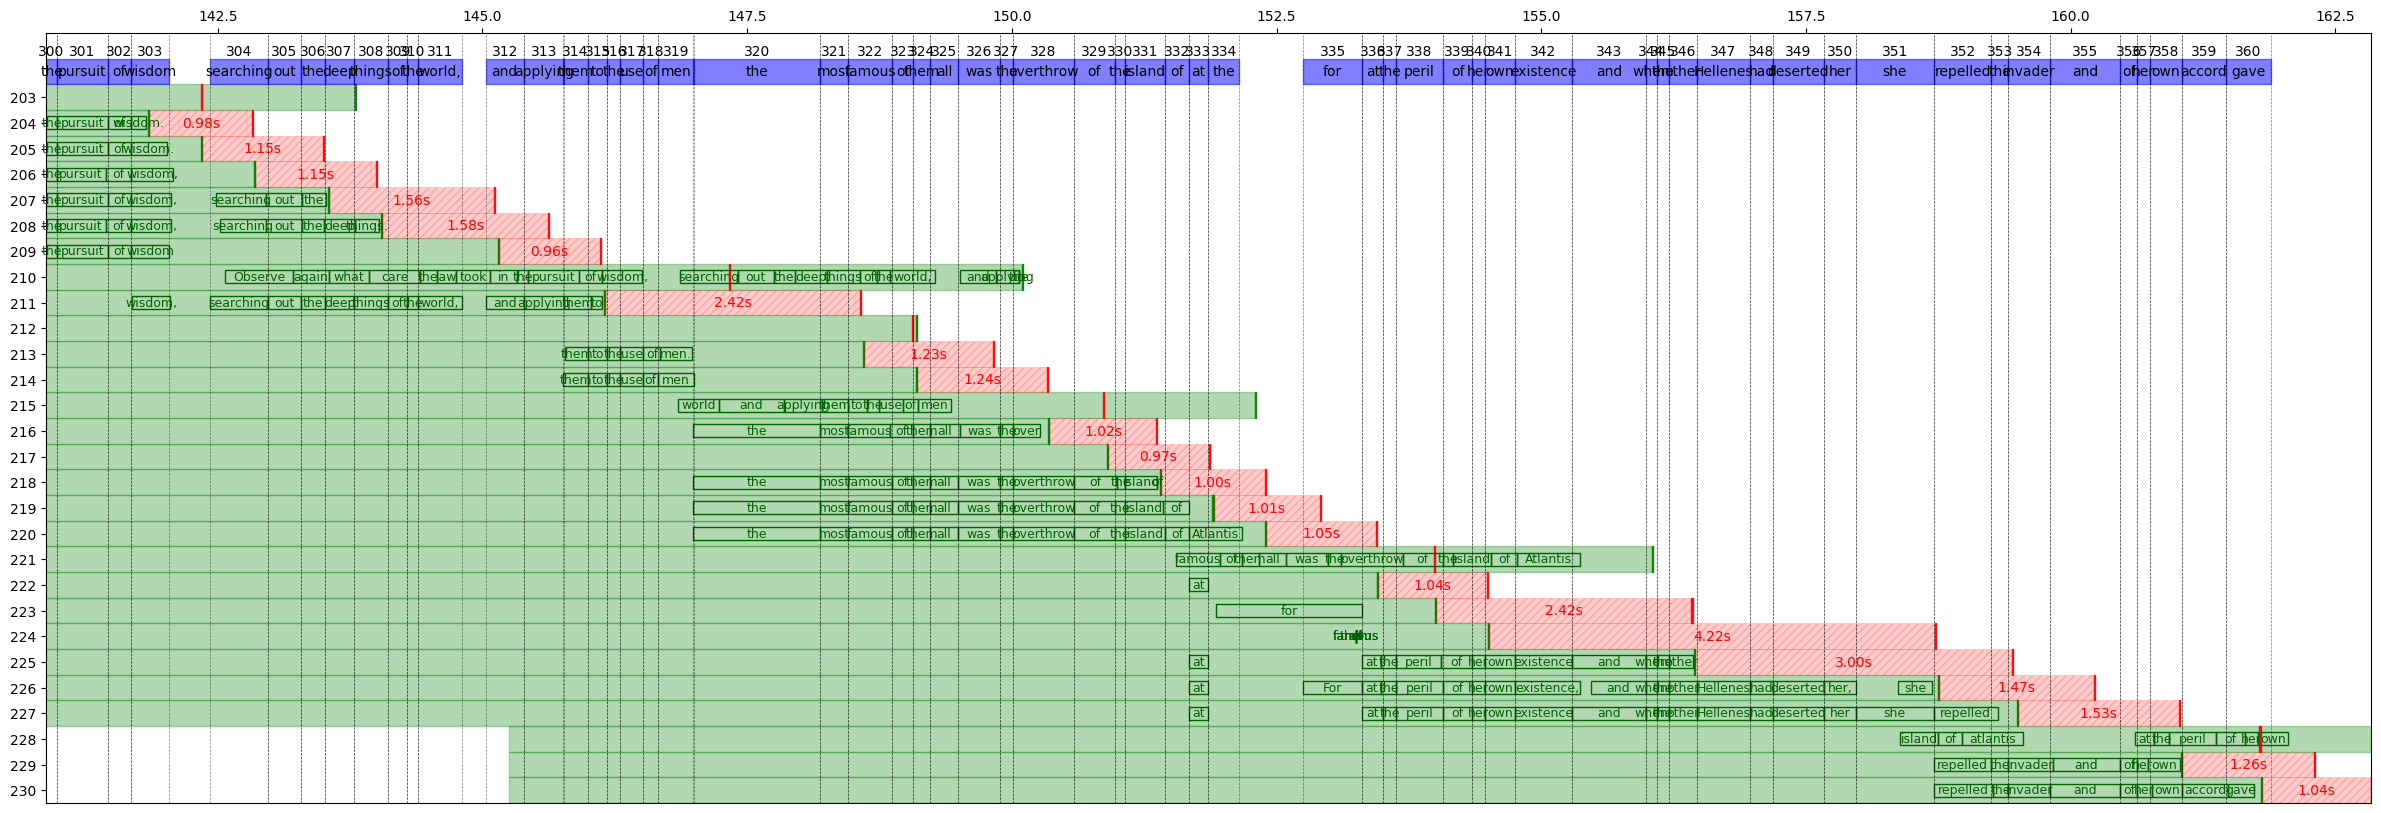

In [29]:
words = final[window_start:window_end]

window_start_t = words[0]["start"]
window_end_t = words[-1]["end"]

# Filter predictions and keep original indices
indexed_predictions = [
    (i, p) for i, p in enumerate(partials)
    if window_start_t <= p["window"][1] and (p["observation_time"] <= window_end_t or p["window"][1] <= window_end_t)
]
indexed_predictions = indexed_predictions[::-1]  # Reverse for display

# Determine max observation time for x-axis limit
max_obs_time = max(window_end_t, max(p["observation_time"] for _, p in indexed_predictions))

fig, ax = plt.subplots(figsize=(30, 10))

for row_index, (original_index, partial) in enumerate(indexed_predictions):
    win_start, win_end = partial["window"]
    obs_time = partial["observation_time"]

    # Green prediction window
    ax.add_patch(Rectangle((win_start, row_index), win_end - win_start, 1, color="green", alpha=0.3))

    # Green bar at window[1]
    marker_width = 0.01
    ax.add_patch(Rectangle((win_end - marker_width / 2, row_index), marker_width, 1, color="green", alpha=0.9))

    # Red delay box
    if obs_time > win_end:
        delay = obs_time - win_end
        ax.add_patch(Rectangle(
            (win_end, row_index), delay, 1,
            color="red", alpha=0.2, hatch='////', linewidth=0.5, fill=True
        ))
        # Delay label
        ax.text(win_end + delay / 2, row_index + 0.5, f"{delay:.2f}s", ha="center", va="center", fontsize=10, color="red")

    # Red bar at observation time
    ax.add_patch(Rectangle((obs_time - marker_width / 2, row_index), marker_width, 1, color="red", alpha=0.9))

    # Word boxes (half-height, dark green frame)
    for word in partial["result"]["result"]:
        if window_start_t <= word["start"] <= window_end_t:
            ax.add_patch(Rectangle(
                (word["start"], row_index + 0.25), word["end"] - word["start"], 0.5,
                edgecolor="darkgreen", facecolor="none", linewidth=1
            ))
            ax.text((word["start"] + word["end"]) / 2, row_index + 0.5, word["word"],
                    ha="center", va="center", fontsize=9, color="darkgreen")

# Draw top word layer (blue)
word_y = len(indexed_predictions)
for i, word in enumerate(words):
    start = word["start"]
    end = word["end"]
    ax.add_patch(Rectangle((start, word_y), end - start, 1, color="blue", alpha=0.5))
    ax.text((start + end) / 2, word_y + 0.5, word["word"], ha="center", va="center", fontsize=10)
    ax.text((start + end) / 2, word_y + 1.3, f"{window_start + i}", ha="center", va="center", fontsize=10, color="black")
    ax.axvline(start, color="black", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.axvline(end, color="black", linestyle="--", linewidth=0.5, alpha=0.5)

# Axes setup
ax.set_xlim(window_start_t, max_obs_time)
ax.set_ylim(0, word_y + 2)
ax.set_yticks([i + 0.5 for i in range(len(indexed_predictions))])
ax.set_yticklabels([str(idx) for idx, _ in indexed_predictions])
ax.xaxis.tick_top()

plt.show()

In [26]:
partials[233]

{'result': {'result': [{'conf': 0.992188,
    'start': 158.71,
    'end': 159.27,
    'word': 'repelled'},
   {'conf': 0.956055, 'start': 159.27, 'end': 159.41, 'word': 'the'},
   {'conf': 0.989014, 'start': 159.41, 'end': 159.81, 'word': 'invader'},
   {'conf': 0.992188, 'start': 159.81, 'end': 160.47, 'word': 'and'},
   {'conf': 0.940918, 'start': 160.47, 'end': 160.63, 'word': 'of'},
   {'conf': 0.993652, 'start': 160.63, 'end': 160.75, 'word': 'her'},
   {'conf': 0.996582, 'start': 160.75, 'end': 161.05, 'word': 'own'},
   {'conf': 0.995605, 'start': 161.05, 'end': 161.47, 'word': 'accord'},
   {'conf': 0.990234, 'start': 161.47, 'end': 161.85, 'word': 'gave'},
   {'conf': 0.987793,
    'start': 161.85,
    'end': 162.32999999999998,
    'word': 'liberty'},
   {'conf': 0.995605,
    'start': 162.32999999999998,
    'end': 162.61,
    'word': 'to'},
   {'conf': 0.994141, 'start': 162.61, 'end': 162.91, 'word': 'all'},
   {'conf': 0.98584, 'start': 162.91, 'end': 163.09, 'word': 'the

In [39]:
def word_first_correct_response(final_index, acceptance_time=1.0):
    '''
    Given the index of a final word, return the first partial response that contains the word
    and the time it was produced.
    '''
    target_word = final[final_index]
    word_start = target_word["start"]
    word_end = target_word["end"]
    word = target_word["word"]
    for i, partial in enumerate(partials):
        if partial["observation_time"] < word_start:
            continue
        for w in partial["result"]["result"]:
            if w["word"] == word and w["start"] >= word_start - acceptance_time and w["start"] <= word_end + acceptance_time:
                return {
                    "timestep": i,
                    "observation_time": partial["observation_time"],
                    "latency": partial["observation_time"] - word_start,
                }

def word_first_final_response(final_index, acceptance_time=1.0):
    '''
    Given the index of a final word, return the partial response after which the word does not change anymore and thus becomes final.
    '''
    target_word = final[final_index]
    word_start = target_word["start"]
    word_end = target_word["end"]
    word = target_word["word"]
    last_found_at_index = None
    candidate = None
    for i, partial in enumerate(partials):
        if partial["observation_time"] < word_start:
            continue
        if (len(partial["result"]["result"])
            and partial["result"]["result"][0]["start"] > word_end + acceptance_time
        ):
            return candidate
        for w in partial["result"]["result"]:
            if w["word"] == word and w["start"] >= word_start - acceptance_time and w["end"] <= word_end + acceptance_time:
                last_found_at_index = i
                if (
                    candidate is None
                    or last_found_at_index < i-1 
                ):
                    candidate = {
                        "timestep": i,
                        "observation_time": partial["observation_time"],
                        "latency": partial["observation_time"] - word_start,
                    }
    return candidate
        
            

wfc = [word_first_correct_response(i, acceptance_time=4.0) for i in range(len(final))]
print([i for i in range(len(final)) if wfc[i] is None])
wfc_latency = np.array([r["latency"] for r in wfc])

ffc = [word_first_final_response(i) for i in range(len(final))]
ffc_latency = np.array([r["latency"] for r in ffc])

[183, 234, 297, 386]


TypeError: 'NoneType' object is not subscriptable

In [ ]:
ffc_latency.mean().item()

2.0420164100480522

In [ ]:
word_first_correct_response(282)

{'timestep': 211,
 'observation_time': 132.54516133666039,
 'latency': 7.3851613366603885}

In [ ]:
word_first_final_response(0)

{'timestep': 1,
 'observation_time': 2.3482836354523897,
 'latency': 2.04828363545239}

In [ ]:
wfc_latency.mean().item()

2.0420164100480522